# Modelagem e simulação

Roberto M. Cesar Jr. - IME - USP

rmcesar@usp.br

Parâmetros sorteados via LCG:
 Cluster 1: μ=[ 1.1  -1.11], Σ=
[[ 1.1  -0.31]
 [-0.31  1.18]]
 Cluster 2: μ=[1.11 1.61], Σ=
[[ 1.15 -0.34]
 [-0.34  1.29]]


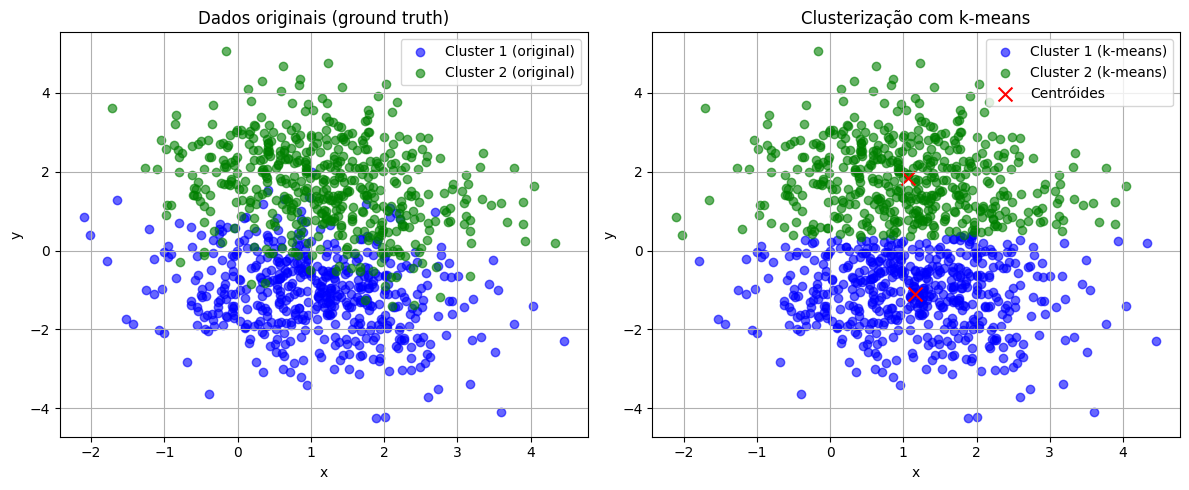

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import time

def lcg(seed, a=1664525, c=1013904223, m=2**32, N=1):
    x = seed
    seq = []
    for _ in range(N):
        x = (a * x + c) % m
        seq.append(x / m)
    return seq

def gerar_parametros_normais(seed):
    r = lcg(seed, N=5)
    mu_x = -5 + 10 * r[0]
    mu_y = -5 + 10 * r[1]
    var_x = 0.5 + r[2]        # variância mínima 0.5
    var_y = 0.5 + r[3]
    covar = (r[4] - 0.5) * np.sqrt(var_x * var_y) * 1.5  # correlação variando em [-0.75σ, 0.75σ]
    mu = np.array([mu_x, mu_y])
    cov = np.array([[var_x, covar], [covar, var_y]])
    return mu, cov

def gerar_dados_bivariados(N, base_seed=None):
    if base_seed is None:
        base_seed = int(time.time() * 1000) % (2**32)

    mu1, cov1 = gerar_parametros_normais(base_seed + 1)
    mu2, cov2 = gerar_parametros_normais(base_seed + 4)

    # Gere números aleatórios usando NumPy mas fixe a seed com LCG
    seed_rng = int(lcg(base_seed + 99, N=1)[0] * 2**32)
    rng = np.random.default_rng(seed_rng)

    X1 = rng.multivariate_normal(mean=mu1, cov=cov1, size=N)
    X2 = rng.multivariate_normal(mean=mu2, cov=cov2, size=N)

    X = np.vstack([X1, X2])
    labels_true = np.array([0]*N + [1]*N)

    print("Parâmetros sorteados via LCG:")
    print(f" Cluster 1: μ={mu1.round(2)}, Σ=\n{cov1.round(2)}")
    print(f" Cluster 2: μ={mu2.round(2)}, Σ=\n{cov2.round(2)}")

    return X, labels_true

def kmeans(X, k, max_iter=100, seed=0):
    np.random.seed(seed)
    indices = np.random.choice(len(X), k, replace=False)
    centroids = X[indices]

    for _ in range(max_iter):
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids

    return labels, centroids

def main():
  X, labels_true = gerar_dados_bivariados(500)
  labels_kmeans, centroids = kmeans(X, k=2, seed=42)

  colors = ['blue', 'green']
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))

  # Ground truth
  for i in range(2):
      axes[0].scatter(X[labels_true == i][:, 0], X[labels_true == i][:, 1],
                      alpha=0.6, color=colors[i], label=f"Cluster {i+1} (original)")
  axes[0].set_title("Dados originais (ground truth)")
  axes[0].set_xlabel("x")
  axes[0].set_ylabel("y")
  axes[0].legend()
  axes[0].grid(True)

  # k-means
  for i in range(2):
      axes[1].scatter(X[labels_kmeans == i][:, 0], X[labels_kmeans == i][:, 1],
                      alpha=0.6, color=colors[i], label=f"Cluster {i+1} (k-means)")
  axes[1].scatter(centroids[:, 0], centroids[:, 1],
                  color='red', marker='x', s=100, label='Centróides')
  axes[1].set_title("Clusterização com k-means")
  axes[1].set_xlabel("x")
  axes[1].set_ylabel("y")
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()

main()